## init

In [1]:
from pyfiles import (parametrics as par,
    complex as cplx,
    matrix as mat,
    vineyard as vin,
    input as inp,
    plot as ourplot,
    grid as grid,
    utils as utils,
    examples as ex,
    sneaky_matrix as sneaky
)
from pyfiles.examples import CameraOpt

# so we don't have to reboot kernel every time we modify classes.py
%load_ext autoreload
%autoreload 2

import numpy as np
from copy import deepcopy

from typing import *

import matplotlib.pyplot as plt
%matplotlib inline

import mars



def export_obj(ex: ex.Example, complex: cplx.complex, faces: List[np.ndarray]):
    out_name = ex.filename.replace('input', 'output')
    name = out_name.split('/')[-1]
    name = name.split('.')[0]
    filename = f'output/{name}-GB{ex.grid_buffer}-GS{ex.grid_size}-MA{ex.medial_axis}'
    if ex.prune_eps is not None:
        filename += f'-peps{ex.prune_eps}'
    filename += '.obj'

    with open(filename, 'w') as f:
        vi = 1
        f.write(f'o {name}\n')
        for triangle in complex.trilist:
            a = triangle.coords[0]
            b = triangle.coords[1]
            c = triangle.coords[2]
            f.write(f'v {a[0]} {a[1]} {a[2]}\n')
            f.write(f'v {b[0]} {b[1]} {b[2]}\n')
            f.write(f'v {c[0]} {c[1]} {c[2]}\n')
            f.write(f'f {vi + 0} {vi + 1} {vi + 2}\n')
            vi += 3

        f.write(f'o {name}-MA{ex.medial_axis}\n')
        for [a, b, c, d] in faces:
            f.write(f'v {a[0]} {a[1]} {a[2]}\n')
            f.write(f'v {b[0]} {b[1]} {b[2]}\n')
            f.write(f'v {c[0]} {c[1]} {c[2]}\n')
            f.write(f'v {d[0]} {d[1]} {d[2]}\n')
            f.write(f'f {vi + 0} {vi + 1} {vi + 2} {vi + 3}\n')
            vi += 4
    print(f'Wrote {filename}')


# thing go bbrrr

|======== Timed report ========
| reduce sparse              :      13.57ms  (13.572ms per; #1)
| py reduce                  :      13.60ms  (13.601ms per; #1)
| rs reduce                  :       9.87ms  ( 9.871ms per; #1)
| vineyard.get_state_at_point:      98.43ms  ( 0.003ms per; #36988)
| reduce_vine: ordering      :   13410.02ms  ( 0.363ms per; #36988)
| from sparse                :       2.32ms  ( 0.386ms per; #6)
| mars.reduce_vine           :     481.10ms  ( 0.013ms per; #36988)
| reduce_vine.almost-all     :    1838.86ms  ( 0.050ms per; #36988)
| py reduce_vine             :   15323.09ms  ( 0.414ms per; #36988)
| rs reduce_vine             :    1314.40ms  ( 0.036ms per; #36988)
| flood_fill_visit           :   17076.43ms  (17076.434ms per; #1)
|==============================


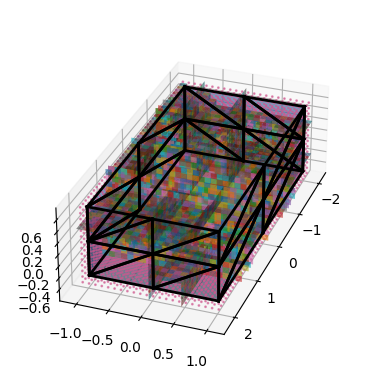

In [19]:
example = ex.rect_test


###################

our_complex = inp.read_obj(example.filename)
gridd = grid.Grid3.from_complex(our_complex, example.grid_size, buffer=example.grid_buffer)

faces = []
swaps = []
class vineyard2(vin.vineyard):
  def get_point_key(self, point: np.ndarray):
    return gridd.cell_of(point)
  
  def prune(self, s1: cplx.simplex, s2: cplx.simplex, old_state, new_state):
    swaps.append((s1, s2, old_state, new_state))

    # if s1.dim() == example.medial_axis:
    #   per_1 = vin.compute_persistence(s1, old_state.ordering, old_state.R)
    #   per_2 = vin.compute_persistence(s2, new_state.ordering, new_state.R)
    #   if per_1 < 0.01 or per_2 < 0.01:
    #     return True

    return vin.prune_euclidean(our_complex, s1, s2, old_state.point, new_state.point, example.prune_eps)

  def on_faustian(self, s1: cplx.simplex, s2: cplx.simplex, old_state, new_state):
    super().on_faustian(s1, s2, old_state.point, new_state.point)
    if s1.dim() == example.medial_axis:
      c1 = gridd.cell_of(old_state.point)
      c2 = gridd.cell_of(new_state.point)
      faces.append(gridd.dual_face(c1, c2))

v = vineyard2(our_complex)


rs_complex = mars.read_from_obj(example.filename)

rs_swaps = []
rs_states = {}
n_edges = gridd.number_of_grid_edges()
visit_count = 0
def visit(new_cell: Tuple[int,int,int], old_cell: Tuple[int,int,int]):
  global visit_count
  visit_count += 1
  perf = visit_count / n_edges * 100
  print(f'visiting {visit_count}/{n_edges} ({perf:.1f}%)\r', end='')
  if old_cell is None:
    center_point = gridd.coordinate(new_cell)
    with utils.Timed('py reduce'):
      v.reduce(center_point)
    with utils.Timed('rs reduce'):
      rs_states[new_cell] = mars.reduce_from_scratch(rs_complex, list(center_point))
  else:
    old_point = gridd.coordinate(old_cell)
    old_state = v.get_state_at_point(old_point)
    new_point = gridd.coordinate(new_cell)
    with utils.Timed('py reduce_vine'):
      v.reduce_vine(old_state, new_point)
    with utils.Timed('rs reduce_vine'):
      rs_old_state = rs_states[old_cell]
      (rs_new_state, swaps) = mars.vineyards_123(rs_complex, rs_old_state, list(new_point))
      # (dim, (i, j)) 

      for (dim, (i, j)) in swaps:
        if dim == example.medial_axis:
          s1 = our_complex.get_simplex(dim, i)
          s2 = our_complex.get_simplex(dim, j)
          rs_swaps.append((s1, s2, old_cell, new_cell))

      rs_states[new_cell] = rs_new_state

with utils.Timed('flood_fill_visit'):
  gridd.flood_fill_visit(gridd.center_index(), visit)
utils.Timed.report()

ourplot.plot_vineyard_results(our_complex, gridd, faces, CameraOpt(azim=20, elev=30))
export_obj(example, our_complex, faces)

(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

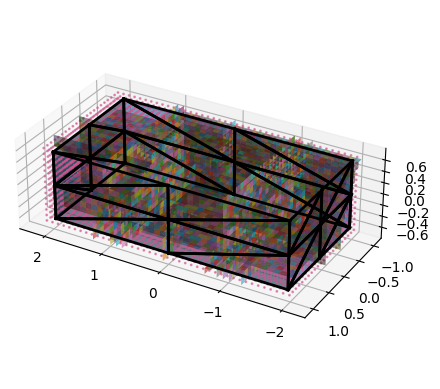

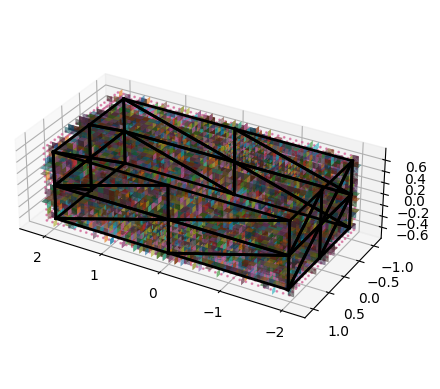

In [41]:
rs_faces = []
for (s1, s2, old_cell, new_cell) in rs_swaps:
  if s1.dim() != example.medial_axis:
    continue

  old_p = gridd.coordinate(old_cell)
  new_p = gridd.coordinate(new_cell)
  grid_dist = np.linalg.norm(old_p - new_p)
  c1 = our_complex.simplex_to_center(s1)
  c2 = our_complex.simplex_to_center(s2)
  c_dist = np.linalg.norm(c1 - c2)
  eps = 0.1
  if c_dist < grid_dist * eps:
    continue
  rs_faces.append(gridd.dual_face(old_cell, new_cell))

ourplot.plot_vineyard_results(our_complex, gridd, faces, CameraOpt(azim=120, elev=30))
ourplot.plot_vineyard_results(our_complex, gridd, rs_faces, CameraOpt(azim=120, elev=30))

|======== Timed report ========
| rs reduce       :      73.73ms  (73.727ms per; #1)
| rs reduce_vine  :    1295.13ms  ( 0.213ms per; #6084)
| flood_fill_visit:    1408.72ms  (1408.718ms per; #1)
|==============================
Wrote output/jungle-gym-GB0.2-GS0.5-MA0-peps0.obj


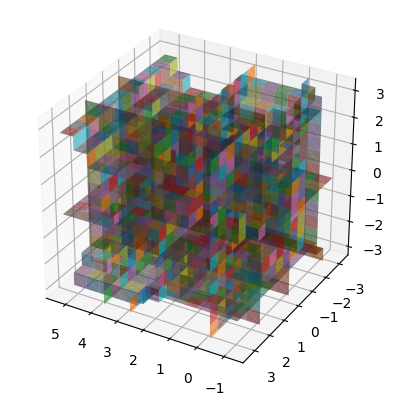

In [2]:
example = ex.junglegym

our_complex = inp.read_obj(example.filename)
gridd = grid.Grid3.from_complex(our_complex, example.grid_size, buffer=example.grid_buffer)

rs_complex = mars.read_from_obj(example.filename)

rs_swaps = []
rs_states = {}
n_edges = gridd.number_of_grid_edges()
visit_count = 0
def visit(new_cell: Tuple[int,int,int], old_cell: Tuple[int,int,int]):
  global visit_count
  visit_count += 1
  perf = visit_count / n_edges * 100
  print(f'visiting {visit_count}/{n_edges} ({perf:.1f}%)\r', end='')
  if old_cell is None:
    center_point = gridd.coordinate(new_cell)
    with utils.Timed('rs reduce'):
      rs_states[new_cell] = mars.reduce_from_scratch(rs_complex, list(center_point))
  else:
    new_point = gridd.coordinate(new_cell)
    with utils.Timed('rs reduce_vine'):
      rs_old_state = rs_states[old_cell]
      (rs_new_state, swaps) = mars.vineyards_123(rs_complex, rs_old_state, list(new_point))
      rs_swaps.append((old_cell, new_cell, swaps))
      rs_states[new_cell] = rs_new_state

with utils.Timed('flood_fill_visit'):
  gridd.flood_fill_visit(gridd.center_index(), visit)
utils.Timed.report()

rs_faces = []
for (old_cell, new_cell, swaps) in rs_swaps:
  state_old = rs_states[old_cell]
  state_new = rs_states[new_cell]

  swaps = swaps.pyclone()
  # swaps.prune_coboundary(rs_complex)
  # swaps.prune_persistence(rs_complex, state_old, state_new, 0.01)
  if example.prune_dist is not None:
    swaps.prune_euclidian(rs_complex, example.prune_dist)

  swaps = list(filter(lambda t: t.dim == example.medial_axis, swaps.v))
  if 0 < len(swaps):
    rs_faces.append(gridd.dual_face(old_cell, new_cell))

ourplot.plot_vineyard_results(our_complex, gridd, rs_faces, CameraOpt(azim=120, elev=30), skip_grid=True)
export_obj(example, our_complex, rs_faces)

Wrote output/u2-GB0.2-GS0.05-MA0-peps0.obj


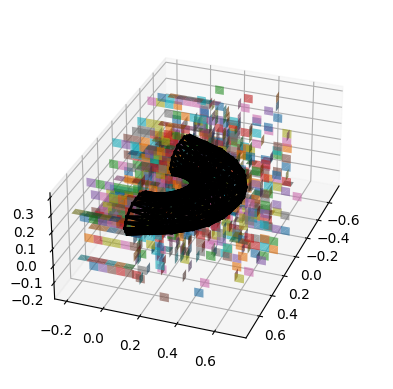

In [39]:
from math import sqrt
rs_faces = []
for (old_cell, new_cell, swaps) in rs_swaps:
  state_old = rs_states[old_cell]
  state_new = rs_states[new_cell]

  swaps = swaps.pyclone()
  swaps.prune_coboundary(rs_complex)
  # swaps.prune_euclidian(rs_complex, 0.12**2)

  swaps = list(filter(lambda t: t.dim == example.medial_axis, swaps.v))
  if 0 < len(swaps):
    rs_faces.append(gridd.dual_face(old_cell, new_cell))

ourplot.plot_vineyard_results(our_complex, gridd, rs_faces, example.camera_opt, skip_grid=True)

export_obj(example, our_complex, rs_faces)